# FluVaccine task generation

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string
from random import shuffle,seed,choices
from faker import Faker
from faker.providers.person.en import Provider
import networkx as nx
import itertools

from utils import Utils
from flu_vaccine import FluVaccine
from dataset_generator import DataSetGenerator

In [2]:
u = Utils()
dg = DataSetGenerator()

## Error test (low complexity)

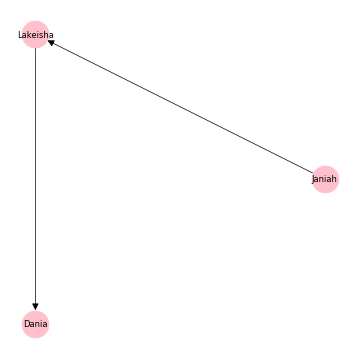


Causal context: A group of friends is considering whether or not to get vaccinated against the flu this year. Janiah will get vaccinated if she was sick for at least 5 days in the previous flu season. Lakeisha will get vaccinated if she was sick for at least 5 days in the previous flu season or if Janiah gets vaccinated. Dania will get vaccinated if she was sick for at least 5 days in the previous flu season or if Lakeisha gets vaccinated. 

Sample context:  During the previous flu season, Janiah was sick for 3 days, Lakeisha was sick for 3 days, and Dania was sick for 7 days.

- Global cause-effect pairs: ('Janiah', 'Dania')
- Local cause-effect pairs: [('Janiah', 'Lakeisha'), ('Lakeisha', 'Dania')]
- Compositions: [[('Janiah', 'Lakeisha'), ('Lakeisha', 'Dania')]]


In [3]:
size = [2,2]
tg = FluVaccine(n_per_bcc = size, 
                bcc_types = ["cycle"]*len(size))
causal_context = tg.get_causal_context()
sample_context = tg.get_sample_context()
print()
print("Causal context:", causal_context)
print()
print("Sample context:", sample_context)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [4]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'Dania': {'Prompt': 'Did Dania get vaccinated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'Janiah': 0, 'Lakeisha': 0, 'Dania': 1},
  'True exogenous': {'BZ83': 0, 'SOGC': 0, 'E744': 1},
  'True response': 1},
 'Lakeisha': {'Prompt': 'Did Lakeisha get vaccinated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'Janiah': 0, 'Lakeisha': 0, 'Dania': 1},
  'True exogenous': {'BZ83': 0, 'SOGC': 0, 'E744': 1},
  'True response': 0}}

In [5]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('Janiah', 'Dania') --
Prompt: Now, suppose that Janiah got vaccinated regardless of all other circumstances. With this new assumption, is Dania happy? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Janiah': 1, 'Lakeisha': 1, 'Dania': 1}
True exogenous: {'BZ83': 0, 'SOGC': 0, 'E744': 1}
True response: 1

-----------------------

-- ('Janiah', 'Lakeisha') --
Prompt: Now, suppose that Janiah got vaccinated regardless of all other circumstances. With this new assumption, is Lakeisha happy? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Janiah': 1, 'Lakeisha': 1, 'Dania': 1}
True exogenous: {'BZ83': 0, 'SOGC': 0, 'E744': 1}
True response: 1

-----------------------

-- ('Lakeisha', 'Dania') --
Prompt: Now, suppose that Lakeisha got vaccinated regardless of all other circumstances. With this new assumption, is Dania happy? Begin your response with

In [6]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('Janiah', 'Dania') --
Prompt: Now, suppose that Janiah did not get vaccinated regardless of all other circumstances. With this new assumption, is Dania happy? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Janiah': 0, 'Lakeisha': 0, 'Dania': 1}
True exogenous: {'BZ83': 0, 'SOGC': 0, 'E744': 1}
True response: 1

-----------------------

-- ('Janiah', 'Lakeisha') --
Prompt: Now, suppose that Janiah did not get vaccinated regardless of all other circumstances. With this new assumption, is Lakeisha happy? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Janiah': 0, 'Lakeisha': 0, 'Dania': 1}
True exogenous: {'BZ83': 0, 'SOGC': 0, 'E744': 1}
True response: 0

-----------------------

-- ('Lakeisha', 'Dania') --
Prompt: Now, suppose that Lakeisha did not get vaccinated regardless of all other circumstances. With this new assumption, is Dania happy?

In [7]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

Janiah  Lakeisha  Dania
0       1         1      1
1       1         1      1
2       0         1      1
3       0         0      1
4       0         0      1

BZ83  SOGC  E744
0     1     0     0
1     1     1     1
2     0     1     1
3     0     0     1
4     0     0     1

In [8]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- Lakeisha = 1 --


Janiah  Lakeisha  Dania
0       1         1      1
1       1         1      1
2       0         1      1
3       0         1      1
4       0         1      1

BZ83  SOGC  E744
0     1     0     0
1     1     1     1
2     0     1     1
3     0     0     1
4     0     0     1


-- Janiah = 1 --


Janiah  Lakeisha  Dania
0       1         1      1
1       1         1      1
2       1         1      1
3       1         1      1
4       1         1      1

BZ83  SOGC  E744
0     1     0     0
1     1     1     1
2     0     1     1
3     0     0     1
4     0     0     1

In [9]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- Lakeisha = 0 --


Janiah  Lakeisha  Dania
0       1         0      0
1       1         0      1
2       0         0      1
3       0         0      1
4       0         0      1

BZ83  SOGC  E744
0     1     0     0
1     1     1     1
2     0     1     1
3     0     0     1
4     0     0     1


-- Janiah = 0 --


Janiah  Lakeisha  Dania
0       0         0      0
1       0         1      1
2       0         1      1
3       0         0      1
4       0         0      1

BZ83  SOGC  E744
0     1     0     0
1     1     1     1
2     0     1     1
3     0     0     1
4     0     0     1

## Error test (moderate complexity)

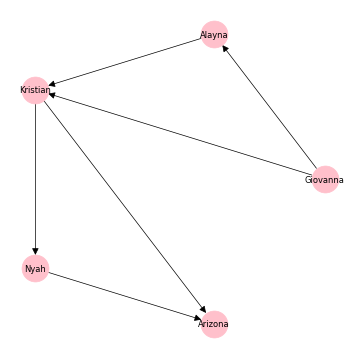


Causal context: A group of friends is considering whether or not to get vaccinated against the flu this year. Giovanna will get vaccinated if she was sick for at least 5 days in the previous flu season. Alayna will get vaccinated if she was sick for at least 5 days in the previous flu season or if Giovanna gets vaccinated. Kristian will get vaccinated if she was sick for at least 5 days in the previous flu season or if Giovanna gets vaccinated or if Alayna gets vaccinated. Nyah will get vaccinated if she was sick for at least 5 days in the previous flu season or if Kristian gets vaccinated. Arizona will get vaccinated if she was sick for at least 5 days in the previous flu season or if Kristian gets vaccinated or if Nyah gets vaccinated. 

Sample context:  During the previous flu season, Giovanna was sick for 3 days, Alayna was sick for 4 days, Kristian was sick for 7 days, Nyah was sick for 4 days, and Arizona was sick for 2 days.

- Global cause-effect pairs: ('Giovanna', 'Arizona')

In [10]:
size = [3,3]
tg = FluVaccine(n_per_bcc = size, 
                bcc_types = ["cycle"]*len(size))
causal_context = tg.get_causal_context()
sample_context = tg.get_sample_context()
print()
print("Causal context:", causal_context)
print()
print("Sample context:", sample_context)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [11]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'Arizona': {'Prompt': 'Did Arizona get vaccinated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'Giovanna': 0,
   'Alayna': 0,
   'Kristian': 1,
   'Nyah': 1,
   'Arizona': 1},
  'True exogenous': {'XS6J': 0, 'ZRMU': 0, '5KYV': 1, 'VG80': 0, 'AR45': 0},
  'True response': 1},
 'Kristian': {'Prompt': 'Did Kristian get vaccinated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'Giovanna': 0,
   'Alayna': 0,
   'Kristian': 1,
   'Nyah': 1,
   'Arizona': 1},
  'True exogenous': {'XS6J': 0, 'ZRMU': 0, '5KYV': 1, 'VG80': 0, 'AR45': 0},
  'True response': 1}}

In [12]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('Giovanna', 'Arizona') --
Prompt: Now, suppose that Giovanna got vaccinated regardless of all other circumstances. With this new assumption, is Arizona happy? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Giovanna': 1, 'Alayna': 1, 'Kristian': 1, 'Nyah': 1, 'Arizona': 1}
True exogenous: {'XS6J': 0, 'ZRMU': 0, '5KYV': 1, 'VG80': 0, 'AR45': 0}
True response: 1

-----------------------

-- ('Giovanna', 'Kristian') --
Prompt: Now, suppose that Giovanna got vaccinated regardless of all other circumstances. With this new assumption, is Kristian happy? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Giovanna': 1, 'Alayna': 1, 'Kristian': 1, 'Nyah': 1, 'Arizona': 1}
True exogenous: {'XS6J': 0, 'ZRMU': 0, '5KYV': 1, 'VG80': 0, 'AR45': 0}
True response: 1

-----------------------

-- ('Kristian', 'Arizona') --
Prompt: Now, suppose that Kristian got va

In [13]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('Giovanna', 'Arizona') --
Prompt: Now, suppose that Giovanna did not get vaccinated regardless of all other circumstances. With this new assumption, is Arizona happy? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Giovanna': 0, 'Alayna': 0, 'Kristian': 1, 'Nyah': 1, 'Arizona': 1}
True exogenous: {'XS6J': 0, 'ZRMU': 0, '5KYV': 1, 'VG80': 0, 'AR45': 0}
True response: 1

-----------------------

-- ('Giovanna', 'Kristian') --
Prompt: Now, suppose that Giovanna did not get vaccinated regardless of all other circumstances. With this new assumption, is Kristian happy? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'Giovanna': 0, 'Alayna': 0, 'Kristian': 1, 'Nyah': 1, 'Arizona': 1}
True exogenous: {'XS6J': 0, 'ZRMU': 0, '5KYV': 1, 'VG80': 0, 'AR45': 0}
True response: 1

-----------------------

-- ('Kristian', 'Arizona') --
Prompt: Now, suppose tha

In [14]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

Giovanna  Alayna  Kristian  Nyah  Arizona
0         1       1         1     1        1
1         1       1         1     1        1
2         0       1         1     1        1
3         0       0         1     1        1
4         0       0         1     1        1

XS6J  ZRMU  5KYV  VG80  AR45
0     1     0     0     1     0
1     1     1     1     0     0
2     0     1     1     0     1
3     0     0     1     1     0
4     0     0     1     1     0

In [15]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- Kristian = 1 --


Giovanna  Alayna  Kristian  Nyah  Arizona
0         1       1         1     1        1
1         1       1         1     1        1
2         0       1         1     1        1
3         0       0         1     1        1
4         0       0         1     1        1

XS6J  ZRMU  5KYV  VG80  AR45
0     1     0     0     1     0
1     1     1     1     0     0
2     0     1     1     0     1
3     0     0     1     1     0
4     0     0     1     1     0


-- Giovanna = 1 --


Giovanna  Alayna  Kristian  Nyah  Arizona
0         1       1         1     1        1
1         1       1         1     1        1
2         1       1         1     1        1
3         1       1         1     1        1
4         1       1         1     1        1

XS6J  ZRMU  5KYV  VG80  AR45
0     1     0     0     1     0
1     1     1     1     0     0
2     0     1     1     0     1
3     0     0     1     1     0
4     0     0     1     1     0

In [16]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- Kristian = 0 --


Giovanna  Alayna  Kristian  Nyah  Arizona
0         1       1         0     1        1
1         1       1         0     0        0
2         0       1         0     0        1
3         0       0         0     1        1
4         0       0         0     1        1

XS6J  ZRMU  5KYV  VG80  AR45
0     1     0     0     1     0
1     1     1     1     0     0
2     0     1     1     0     1
3     0     0     1     1     0
4     0     0     1     1     0


-- Giovanna = 0 --


Giovanna  Alayna  Kristian  Nyah  Arizona
0         0       0         0     1        1
1         0       1         1     1        1
2         0       1         1     1        1
3         0       0         1     1        1
4         0       0         1     1        1

XS6J  ZRMU  5KYV  VG80  AR45
0     1     0     0     1     0
1     1     1     1     0     0
2     0     1     1     0     1
3     0     0     1     1     0
4     0     0     1     1     0

In [17]:
glo = [tg.get_global()]
loc = tg.get_local()
comp = tg.get_compositions()

print(glo)
print(loc)
print(comp)

[('Giovanna', 'Arizona')]
[('Giovanna', 'Kristian'), ('Kristian', 'Arizona')]
[[('Giovanna', 'Kristian'), ('Kristian', 'Arizona')]]


In [18]:
# Get PNS and compare to ATE.
results_dict = dict()
for n in [5,10,50,100,500,1000,5000]:
    pair_dict = dict()
    for pair in glo+loc:
        df_cf, df_noise = tg.sample_scm(n = n,
                                        intervene_node = pair[0],
                                        intervene_value = 1)
        df_cf.rename(columns={pair[1]: 'True (cause = True)'}, inplace = True)
        df_cf_0, df_noise = tg.sample_scm(n = n,
                                          intervene_node = pair[0],
                                          intervene_value = 0)
        df_cf["True (cause = False)"] = df_cf_0[pair[1]]
        display(df_cf.head(5))
        print("\n-- {} | n = {} --".format(pair,n))
        pns = dg.get_pns_ate(df_cf)
        pair_dict[pair] = pns
    results_dict[n] = pair_dict

Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     1
1         1       1         1     1                    1                     1
2         1       1         1     1                    1                     1
3         1       1         1     1                    1                     1
4         1       1         1     1                    1                     1


-- ('Giovanna', 'Arizona') | n = 5 --
-- PNS = 0.0 | ATE = 0.0 --


Giovanna  Alayna  True (cause = True)  Nyah  Arizona  True (cause = False)
0         1       1                    1     1        1                     0
1         1       1                    1     1        1                     1
2         1       1                    1     1        1                     1
3         1       1                    1     1        1                     1
4         1       1                    1     1        1                     1


-- ('Giovanna', 'Kristian') | n = 5 --
-- PNS = 0.2 | ATE = 0.19999999999999996 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     1
1         1       1         1     1                    1                     0
2         0       1         1     1                    1                     1
3         0       0         1     1                    1                     1
4         0       0         1     1                    1                     1


-- ('Kristian', 'Arizona') | n = 5 --
-- PNS = 0.2 | ATE = 0.19999999999999996 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     0
1         1       1         1     1                    1                     1
2         1       1         1     1                    1                     1
3         1       1         1     1                    1                     1
4         1       1         1     1                    1                     1


-- ('Giovanna', 'Arizona') | n = 10 --
-- PNS = 0.1 | ATE = 0.09999999999999998 --


Giovanna  Alayna  True (cause = True)  Nyah  Arizona  True (cause = False)
0         1       1                    1     1        1                     0
1         1       1                    1     1        1                     1
2         1       1                    1     1        1                     1
3         1       1                    1     1        1                     1
4         1       1                    1     1        1                     1


-- ('Giovanna', 'Kristian') | n = 10 --
-- PNS = 0.1 | ATE = 0.09999999999999998 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     0
1         1       1         1     1                    1                     1
2         0       1         1     1                    1                     1
3         0       1         1     1                    1                     1
4         0       1         1     1                    1                     1


-- ('Kristian', 'Arizona') | n = 10 --
-- PNS = 0.3 | ATE = 0.30000000000000004 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     1
1         1       1         1     1                    1                     1
2         1       1         1     1                    1                     1
3         1       1         1     1                    1                     1
4         1       1         1     1                    1                     1


-- ('Giovanna', 'Arizona') | n = 50 --
-- PNS = 0.04 | ATE = 0.040000000000000036 --


Giovanna  Alayna  True (cause = True)  Nyah  Arizona  True (cause = False)
0         1       1                    1     1        1                     1
1         1       1                    1     1        1                     1
2         1       1                    1     1        1                     1
3         1       1                    1     1        1                     1
4         1       1                    1     1        1                     1


-- ('Giovanna', 'Kristian') | n = 50 --
-- PNS = 0.18 | ATE = 0.18000000000000005 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     0
1         1       1         1     1                    1                     1
2         0       1         1     1                    1                     0
3         0       1         1     1                    1                     1
4         0       0         1     1                    1                     1


-- ('Kristian', 'Arizona') | n = 50 --
-- PNS = 0.24 | ATE = 0.24 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     1
1         1       1         1     1                    1                     1
2         1       1         1     1                    1                     1
3         1       1         1     1                    1                     1
4         1       1         1     1                    1                     1


-- ('Giovanna', 'Arizona') | n = 100 --
-- PNS = 0.06 | ATE = 0.06000000000000005 --


Giovanna  Alayna  True (cause = True)  Nyah  Arizona  True (cause = False)
0         1       1                    1     1        1                     1
1         1       1                    1     1        1                     1
2         1       1                    1     1        1                     1
3         1       1                    1     1        1                     1
4         1       1                    1     1        1                     1


-- ('Giovanna', 'Kristian') | n = 100 --
-- PNS = 0.26 | ATE = 0.26 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     1
1         1       1         1     1                    1                     0
2         0       1         1     1                    1                     1
3         0       1         1     1                    1                     1
4         0       1         1     1                    1                     1


-- ('Kristian', 'Arizona') | n = 100 --
-- PNS = 0.27 | ATE = 0.27 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     1
1         1       1         1     1                    1                     0
2         1       1         1     1                    1                     1
3         1       1         1     1                    1                     1
4         1       1         1     1                    1                     1


-- ('Giovanna', 'Arizona') | n = 500 --
-- PNS = 0.056 | ATE = 0.05600000000000005 --


Giovanna  Alayna  True (cause = True)  Nyah  Arizona  True (cause = False)
0         1       1                    1     1        1                     0
1         1       1                    1     1        1                     0
2         1       1                    1     1        1                     1
3         1       1                    1     1        1                     0
4         1       1                    1     1        1                     1


-- ('Giovanna', 'Kristian') | n = 500 --
-- PNS = 0.25 | ATE = 0.25 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     1
1         1       1         1     1                    1                     0
2         0       1         1     1                    1                     1
3         0       0         1     1                    1                     1
4         0       1         1     1                    1                     1


-- ('Kristian', 'Arizona') | n = 500 --
-- PNS = 0.226 | ATE = 0.22599999999999998 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     1
1         1       1         1     1                    1                     1
2         1       1         1     1                    1                     1
3         1       1         1     1                    1                     1
4         1       1         1     1                    1                     1


-- ('Giovanna', 'Arizona') | n = 1000 --
-- PNS = 0.059 | ATE = 0.05900000000000005 --


Giovanna  Alayna  True (cause = True)  Nyah  Arizona  True (cause = False)
0         1       1                    1     1        1                     1
1         1       1                    1     1        1                     0
2         1       1                    1     1        1                     1
3         1       1                    1     1        1                     0
4         1       1                    1     1        1                     1


-- ('Giovanna', 'Kristian') | n = 1000 --
-- PNS = 0.251 | ATE = 0.251 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     0
1         1       1         1     1                    1                     1
2         0       0         1     1                    1                     0
3         0       0         1     1                    1                     1
4         0       1         1     1                    1                     1


-- ('Kristian', 'Arizona') | n = 1000 --
-- PNS = 0.257 | ATE = 0.257 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     1
1         1       1         1     1                    1                     1
2         1       1         1     1                    1                     1
3         1       1         1     1                    1                     1
4         1       1         1     1                    1                     1


-- ('Giovanna', 'Arizona') | n = 5000 --
-- PNS = 0.0632 | ATE = 0.06320000000000003 --


Giovanna  Alayna  True (cause = True)  Nyah  Arizona  True (cause = False)
0         1       1                    1     1        1                     1
1         1       1                    1     1        1                     1
2         1       1                    1     1        1                     0
3         1       1                    1     1        1                     1
4         1       1                    1     1        1                     1


-- ('Giovanna', 'Kristian') | n = 5000 --
-- PNS = 0.2456 | ATE = 0.24560000000000004 --


Giovanna  Alayna  Kristian  Nyah  True (cause = True)  True (cause = False)
0         1       1         1     1                    1                     0
1         1       1         1     1                    1                     1
2         0       0         1     1                    1                     1
3         0       1         1     1                    1                     0
4         0       1         1     1                    1                     0


-- ('Kristian', 'Arizona') | n = 5000 --
-- PNS = 0.2532 | ATE = 0.2532 --


In [19]:
for n,res in results_dict.items():
    print("\n-- n = {} --".format(n))
    comp_pns = 1
    for pair,pns in res.items():
        if pair == glo[0]:
            global_pns = pns
        else:
            comp_pns *= pns
    print("Global PNS  =", global_pns)
    print("Composition =", comp_pns)


-- n = 5 --
Global PNS  = 0.0
Composition = 0.04000000000000001

-- n = 10 --
Global PNS  = 0.1
Composition = 0.03

-- n = 50 --
Global PNS  = 0.04
Composition = 0.043199999999999995

-- n = 100 --
Global PNS  = 0.06
Composition = 0.07020000000000001

-- n = 500 --
Global PNS  = 0.056
Composition = 0.0565

-- n = 1000 --
Global PNS  = 0.059
Composition = 0.064507

-- n = 5000 --
Global PNS  = 0.0632
Composition = 0.06218592


In [20]:
results_dict

{5: {('Giovanna', 'Arizona'): 0.0,
  ('Giovanna', 'Kristian'): 0.2,
  ('Kristian', 'Arizona'): 0.2},
 10: {('Giovanna', 'Arizona'): 0.1,
  ('Giovanna', 'Kristian'): 0.1,
  ('Kristian', 'Arizona'): 0.3},
 50: {('Giovanna', 'Arizona'): 0.04,
  ('Giovanna', 'Kristian'): 0.18,
  ('Kristian', 'Arizona'): 0.24},
 100: {('Giovanna', 'Arizona'): 0.06,
  ('Giovanna', 'Kristian'): 0.26,
  ('Kristian', 'Arizona'): 0.27},
 500: {('Giovanna', 'Arizona'): 0.056,
  ('Giovanna', 'Kristian'): 0.25,
  ('Kristian', 'Arizona'): 0.226},
 1000: {('Giovanna', 'Arizona'): 0.059,
  ('Giovanna', 'Kristian'): 0.251,
  ('Kristian', 'Arizona'): 0.257},
 5000: {('Giovanna', 'Arizona'): 0.0632,
  ('Giovanna', 'Kristian'): 0.2456,
  ('Kristian', 'Arizona'): 0.2532}}

## Error test (high complexity)

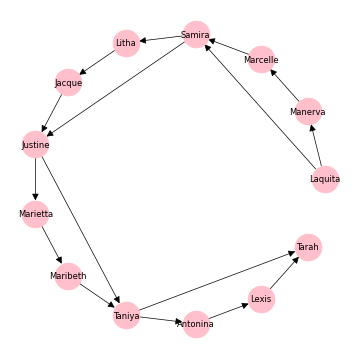


Causal context: A group of friends is considering whether or not to get vaccinated against the flu this year. Laquita will get vaccinated if she was sick for at least 5 days in the previous flu season. Manerva will get vaccinated if she was sick for at least 5 days in the previous flu season or if Laquita gets vaccinated. Marcelle will get vaccinated if she was sick for at least 5 days in the previous flu season or if Manerva gets vaccinated. Samira will get vaccinated if she was sick for at least 5 days in the previous flu season or if Laquita gets vaccinated or if Marcelle gets vaccinated. Litha will get vaccinated if she was sick for at least 5 days in the previous flu season or if Samira gets vaccinated. Jacque will get vaccinated if she was sick for at least 5 days in the previous flu season or if Litha gets vaccinated. Justine will get vaccinated if she was sick for at least 5 days in the previous flu season or if Samira gets vaccinated or if Jacque gets vaccinated. Marietta wil

In [21]:
size = [4,4,4,4]
tg = FluVaccine(n_per_bcc = size, 
                bcc_types = ["cycle"]*len(size))
causal_context = tg.get_causal_context()
sample_context = tg.get_sample_context()
print()
print("Causal context:", causal_context)
print()
print("Sample context:", sample_context)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

## Generate dataset

In [22]:
# x levels of graphical complexity (captured by BCC size).
# y tasks per graphical complexity level.
# z samples per task.
# = x*y*z subtasks.
graph_sizes = [[3,3,3]]
n_tasks_per_size = 3
n_samples_per_task = 5000

df = dg.get_dataset(task_generator = FluVaccine,
                    graph_sizes = graph_sizes,
                    n_tasks_per_size = n_tasks_per_size,
                    n_samples_per_task = n_samples_per_task)

display(df)

Task ID  Context ID  Sample ID Nodes per BCC  \
0         0.0           0          0     [3, 3, 3]   
1         0.1           0          1     [3, 3, 3]   
2         0.2           0          2     [3, 3, 3]   
3         0.3           0          3     [3, 3, 3]   
4         0.4           0          4     [3, 3, 3]   
...       ...         ...        ...           ...   
14995  2.4995           2       4995     [3, 3, 3]   
14996  2.4996           2       4996     [3, 3, 3]   
14997  2.4997           2       4997     [3, 3, 3]   
14998  2.4998           2       4998     [3, 3, 3]   
14999  2.4999           2       4999     [3, 3, 3]   

                                    DAG adjacency matrix  \
0      [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   
1      [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   
2      [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   
3      [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   
4      [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   
...                                                  ...   
14995  [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   
14996  [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   
14997  [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   
14998  [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   
14999  [[0, 1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...   

                                               DAG nodes  \
0      [Maddison, Joann, Kaitlyn, Lucina, Tennille, F...   
1      [Maddison, Joann, Kaitlyn, Lucina, Tennille, F...   
2      [Maddison, Joann, Kaitlyn, Lucina, Tennille, F...   
3      [Maddison, Joann, Kaitlyn, Lucina, Tennille, F...   
4      [Maddison, Joann, Kaitlyn, Lucina, Tennille, F...   
...                                                  ...   
14995  [Trena, Cadence, Vicie, Wilhelmina, Meggan, Br...   
14996  [Trena, Cadence, Vicie, Wilhelmina, Meggan, Br...   
14997  [Trena, Cadence, Vicie, Wilhelmina, Meggan, Br...   
14998  [Trena, Cadence, Vicie, Wilhelmina, Meggan, Br...   
14999  [Trena, Cadence, Vicie, Wilhelmina, Meggan, Br...   

                                    CCT adjacency matrix  \
0      [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   
1      [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   
2      [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   
3      [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   
4      [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   
...                                                  ...   
14995  [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   
14996  [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   
14997  [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   
14998  [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   
14999  [[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...   

                                    CCT nodes  \
0      [Maddison, Kaitlyn, Tennille, Araceli]   
1      [Maddison, Kaitlyn, Tennille, Araceli]   
2      [Maddison, Kaitlyn, Tennille, Araceli]   
3      [Maddison, Kaitlyn, Tennille, Araceli]   
4      [Maddison, Kaitlyn, Tennille, Araceli]   
...                                       ...   
14995            [Trena, Vicie, Meggan, Jill]   
14996            [Trena, Vicie, Meggan, Jill]   
14997            [Trena, Vicie, Meggan, Jill]   
14998            [Trena, Vicie, Meggan, Jill]   
14999            [Trena, Vicie, Meggan, Jill]   

                              Exogenous variables  \
0      [MI6I, T6T2, B3WP, DUM2, 2FVN, 7IOG, BKE2]   
1      [MI6I, T6T2, B3WP, DUM2, 2FVN, 7IOG, BKE2]   
2      [MI6I, T6T2, B3WP, DUM2, 2FVN, 7IOG, BKE2]   
3      [MI6I, T6T2, B3WP, DUM2, 2FVN, 7IOG, BKE2]   
4      [MI6I, T6T2, B3WP, DUM2, 2FVN, 7IOG, BKE2]   
...                                           ...   
14995  [AX7D, P7P8, M178, HJPL, YN7K, L2NN, HSR9]   
14996  [AX7D, P7P8, M178, HJPL, YN7K, L2NN, HSR9]   
14997  [AX7D, P7P8, M178, HJPL, YN7K, L2NN, HSR9]   
14998  [AX7D, P7P8, M178, HJPL, YN7K, L2NN, HSR9]   
14999  [AX7D, P7P8, M1

In [23]:
# Process prompts.
df_factual, df_cf = dg.process_prompts()
display(df_factual)
display(df_cf)

Task ID  Context ID  Sample ID Nodes per BCC    Effect  \
0         0.0           0          0     [3, 3, 3]   Araceli   
1         0.0           0          0     [3, 3, 3]   Kaitlyn   
2         0.0           0          0     [3, 3, 3]  Tennille   
3         0.1           0          1     [3, 3, 3]   Araceli   
4         0.1           0          1     [3, 3, 3]   Kaitlyn   
...       ...         ...        ...           ...       ...   
44995  2.4998           2       4998     [3, 3, 3]     Vicie   
44996  2.4998           2       4998     [3, 3, 3]    Meggan   
44997  2.4999           2       4999     [3, 3, 3]      Jill   
44998  2.4999           2       4999     [3, 3, 3]     Vicie   
44999  2.4999           2       4999     [3, 3, 3]    Meggan   

                                                  Prompt  True  
0      A group of friends is considering whether or n...     1  
1      A group of friends is considering whether or n...     0  
2      A group of friends is considering whether or n...     0  
3      A group of friends is considering whether or n...     1  
4      A group of friends is considering whether or n...     1  
...                                                  ...   ...  
44995  A group of friends is considering whether or n...     1  
44996  A group of friends is considering whether or n...     1  
44997  A group of friends is considering whether or n...     1  
44998  A group of friends is considering whether or n...     1  
44999  A group of friends is considering whether or n...     1  

[45000 rows x 7 columns]

Task ID  Context ID  Sample ID Nodes per BCC     Cause-effect pair  \
0         0.0           0          0     [3, 3, 3]   (Maddison, Araceli)   
1         0.0           0          0     [3, 3, 3]   (Maddison, Kaitlyn)   
2         0.0           0          0     [3, 3, 3]  (Maddison, Tennille)   
3         0.0           0          0     [3, 3, 3]   (Kaitlyn, Tennille)   
4         0.0           0          0     [3, 3, 3]    (Kaitlyn, Araceli)   
...       ...         ...        ...           ...                   ...   
89995  2.4999           2       4999     [3, 3, 3]        (Trena, Vicie)   
89996  2.4999           2       4999     [3, 3, 3]       (Trena, Meggan)   
89997  2.4999           2       4999     [3, 3, 3]       (Vicie, Meggan)   
89998  2.4999           2       4999     [3, 3, 3]         (Vicie, Jill)   
89999  2.4999           2       4999     [3, 3, 3]        (Meggan, Jill)   

          Cause    Effect                              Prompt (cause = True)  \
0      Maddison   Araceli  A group of friends is considering whether or n...   
1      Maddison   Kaitlyn  A group of friends is considering whether or n...   
2      Maddison  Tennille  A group of friends is considering whether or n...   
3       Kaitlyn  Tennille  A group of friends is considering whether or n...   
4       Kaitlyn   Araceli  A group of friends is considering whether or n...   
...         ...       ...                                                ...   
89995     Trena     Vicie  A group of friends is considering whether or n...   
89996     Trena    Meggan  A group of friends is considering whether or n...   
89997     Vicie    Meggan  A group of friends is considering whether or n...   
89998     Vicie      Jill  A group of friends is considering whether or n...   
89999    Meggan      Jill  A group of friends is considering whether or n...   

       True (cause = True)                             Prompt (cause = False)  \
0                        1  A group of friends is considering whether or n...   
1                        1  A group of friends is considering whether or n...   
2                        1  A group of friends is considering whether or n...   
3                        1  A group of friends is considering whether or n...   
4                        1  A group of friends is considering whether or n...   
...                    ...                                                ...   
89995                    1  A group of friends is considering whether or n...   
89996                    1  A group of friends is considering whether or n...   
89997                    1  A group of friends is considering whether or n...   
89998                    1  A group of friends is considering whether or n...   
89999                    1  A group of friends is considering whether or n...   

       True (cause = False)  
0                         1  
1                         0  
2                         0  
3                         0  
4                         1  
...                     ...  
89995                     1  
89996                     1  
89997                     1  
89998                     1  
89999                     1  

[90000 rows x 11 columns]

In [24]:
pns_dict = dg.get_pns_dict(verbose = True)
pns_dict

-- PNS = 0.0164 | ATE = 0.01639999999999997 --
-- PNS = 0.2474 | ATE = 0.24739999999999995 --
-- PNS = 0.0612 | ATE = 0.06120000000000003 --
-- PNS = 0.2544 | ATE = 0.25439999999999996 --
-- PNS = 0.0664 | ATE = 0.06640000000000001 --
-- PNS = 0.2566 | ATE = 0.25660000000000005 --
-- PNS = 0.0148 | ATE = 0.014800000000000035 --
-- PNS = 0.2482 | ATE = 0.24819999999999998 --
-- PNS = 0.0654 | ATE = 0.06540000000000001 --
-- PNS = 0.2492 | ATE = 0.24919999999999998 --
-- PNS = 0.063 | ATE = 0.06299999999999994 --
-- PNS = 0.2458 | ATE = 0.24580000000000002 --
-- PNS = 0.0144 | ATE = 0.014399999999999968 --
-- PNS = 0.2592 | ATE = 0.2592 --
-- PNS = 0.0636 | ATE = 0.06359999999999999 --
-- PNS = 0.25 | ATE = 0.25 --
-- PNS = 0.061 | ATE = 0.061000000000000054 --
-- PNS = 0.255 | ATE = 0.255 --


{0: {"('Maddison', 'Araceli')": 0.0164,
  "('Maddison', 'Kaitlyn')": 0.2474,
  "('Maddison', 'Tennille')": 0.0612,
  "('Kaitlyn', 'Tennille')": 0.2544,
  "('Kaitlyn', 'Araceli')": 0.0664,
  "('Tennille', 'Araceli')": 0.2566,
  "[('Maddison', 'Kaitlyn'), ('Kaitlyn', 'Tennille'), ('Tennille', 'Araceli')]": 0.016150034496000002,
  "[('Maddison', 'Kaitlyn'), ('Kaitlyn', 'Araceli')]": 0.016427360000000002,
  "[('Maddison', 'Tennille'), ('Tennille', 'Araceli')]": 0.01570392},
 1: {"('Alexandrea', 'Patrice')": 0.0148,
  "('Alexandrea', 'Velvet')": 0.2482,
  "('Alexandrea', 'Loretto')": 0.0654,
  "('Velvet', 'Loretto')": 0.2492,
  "('Velvet', 'Patrice')": 0.063,
  "('Loretto', 'Patrice')": 0.2458,
  "[('Alexandrea', 'Velvet'), ('Velvet', 'Loretto'), ('Loretto', 'Patrice')]": 0.015203083951999999,
  "[('Alexandrea', 'Velvet'), ('Velvet', 'Patrice')]": 0.0156366,
  "[('Alexandrea', 'Loretto'), ('Loretto', 'Patrice')]": 0.01607532},
 2: {"('Trena', 'Jill')": 0.0144,
  "('Trena', 'Vicie')": 0.2592

In [25]:
threshold_dict = dg.get_internal_consistency_thresholds(multiplier = 1.25)
threshold_dict

{0: {"[('Maddison', 'Kaitlyn'), ('Kaitlyn', 'Tennille'), ('Tennille', 'Araceli')]": 0.019052248780487748,
  "[('Maddison', 'Kaitlyn'), ('Kaitlyn', 'Araceli')]": 0.0020853658536585805,
  "[('Maddison', 'Tennille'), ('Tennille', 'Araceli')]": 0.05305487804878061},
 1: {"[('Alexandrea', 'Velvet'), ('Velvet', 'Loretto'), ('Loretto', 'Patrice')]": 0.034044252702702546,
  "[('Alexandrea', 'Velvet'), ('Velvet', 'Patrice')]": 0.07065878378378376,
  "[('Alexandrea', 'Loretto'), ('Loretto', 'Patrice')]": 0.10771283783783782},
 2: {"[('Trena', 'Vicie'), ('Vicie', 'Meggan'), ('Meggan', 'Jill')]": 0.1843750000000001,
  "[('Trena', 'Vicie'), ('Vicie', 'Jill')]": 0.12249999999999982,
  "[('Trena', 'Meggan'), ('Meggan', 'Jill')]": 0.15781250000000002}}

In [26]:
df_cf[df_cf["Context ID"] == 0]

Task ID  Context ID  Sample ID Nodes per BCC     Cause-effect pair  \
0         0.0           0          0     [3, 3, 3]   (Maddison, Araceli)   
1         0.0           0          0     [3, 3, 3]   (Maddison, Kaitlyn)   
2         0.0           0          0     [3, 3, 3]  (Maddison, Tennille)   
3         0.0           0          0     [3, 3, 3]   (Kaitlyn, Tennille)   
4         0.0           0          0     [3, 3, 3]    (Kaitlyn, Araceli)   
...       ...         ...        ...           ...                   ...   
29995  0.4999           0       4999     [3, 3, 3]   (Maddison, Kaitlyn)   
29996  0.4999           0       4999     [3, 3, 3]  (Maddison, Tennille)   
29997  0.4999           0       4999     [3, 3, 3]   (Kaitlyn, Tennille)   
29998  0.4999           0       4999     [3, 3, 3]    (Kaitlyn, Araceli)   
29999  0.4999           0       4999     [3, 3, 3]   (Tennille, Araceli)   

          Cause    Effect                              Prompt (cause = True)  \
0      Maddison   Araceli  A group of friends is considering whether or n...   
1      Maddison   Kaitlyn  A group of friends is considering whether or n...   
2      Maddison  Tennille  A group of friends is considering whether or n...   
3       Kaitlyn  Tennille  A group of friends is considering whether or n...   
4       Kaitlyn   Araceli  A group of friends is considering whether or n...   
...         ...       ...                                                ...   
29995  Maddison   Kaitlyn  A group of friends is considering whether or n...   
29996  Maddison  Tennille  A group of friends is considering whether or n...   
29997   Kaitlyn  Tennille  A group of friends is considering whether or n...   
29998   Kaitlyn   Araceli  A group of friends is considering whether or n...   
29999  Tennille   Araceli  A group of friends is considering whether or n...   

       True (cause = True)                             Prompt (cause = False)  \
0                        1  A group of friends is considering whether or n...   
1                        1  A group of friends is considering whether or n...   
2                        1  A group of friends is considering whether or n...   
3                        1  A group of friends is considering whether or n...   
4                        1  A group of friends is considering whether or n...   
...                    ...                                                ...   
29995                    1  A group of friends is considering whether or n...   
29996                    1  A group of friends is considering whether or n...   
29997                    1  A group of friends is considering whether or n...   
29998                    1  A group of friends is considering whether or n...   
29999                    1  A group of friends is considering whether or n...   

       True (cause = False)  
0                         1  
1                         0  
2                         0  
3                         0  
4                         1  
...                     ...  
29995                     0  
29996                     1  
29997                     1  
29998                     1  
29999                     1  

[30000 rows x 11 columns]

## End of document